OK, thus far we have been talking about linear models. All these can be viewed as a single-layer neural net. The next step is to move on to multi-layer nets. Training these is a bit more involved, and implementing from scratch requires time and effort. Instead, we just use well-established libraries. I prefer PyTorch, which is based on an earlier library called Torch (designed for training neural nets via backprop).

In [1]:
import numpy as np
import torch
import torchvision

Torch handles data types a bit differently. Everything in torch is a *tensor*.

In [2]:
a = np.random.rand(2,3)
print(a)

b = torch.from_numpy(a)
print(b)

[[0.2383608  0.96354555 0.84249618]
 [0.91334609 0.35468588 0.23848747]]
tensor([[0.2384, 0.9635, 0.8425],
        [0.9133, 0.3547, 0.2385]], dtype=torch.float64)


The idea in Torch is that tensors allow for easy forward (function evaluations) and backward (gradient) passes.

In [3]:
A = torch.rand(2,2)
b = torch.rand(2,1)
x = torch.rand(2,1, requires_grad=True)

y = torch.matmul(A,x) + b

print(y)
z = y.sum()
print(z)
z.backward()
print(x.grad)
print(x)

tensor([[0.8770],
        [0.5142]], grad_fn=<AddBackward0>)
tensor(1.3912, grad_fn=<SumBackward0>)
tensor([[1.2298],
        [0.4228]])
tensor([[0.2733],
        [0.0508]], requires_grad=True)


Notice how the backward pass computed the gradients using autograd. OK, enough background. Time to train some networks.

In [4]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())


Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
print(len(trainingdata),len(testdata))

60000 10000


OK, same size as MNIST. Let's display a few images.

In [6]:
image, label = trainingdata[0]
print(image.shape, label)

torch.Size([1, 28, 28]) 9


Hmm, it is a tensor, not an array. We need to postprocess to use matplotlib.

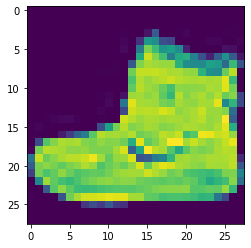

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(image.squeeze().numpy())
plt.show()

Cool! Let's try plotting a few images. (Later).

In [8]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)

In [9]:
images, labels = iter(trainDataLoader).next()
print(images.size(), labels)

torch.Size([64, 1, 28, 28]) tensor([0, 7, 3, 2, 3, 3, 6, 4, 5, 4, 5, 1, 1, 8, 2, 5, 6, 0, 0, 0, 3, 3, 6, 1,
        7, 8, 2, 6, 7, 2, 5, 8, 5, 4, 8, 2, 5, 4, 6, 2, 2, 0, 3, 6, 1, 7, 6, 0,
        8, 1, 9, 8, 5, 5, 9, 6, 5, 7, 3, 1, 2, 4, 6, 7])


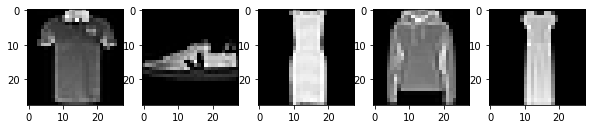

In [10]:
plt.figure(figsize=(10,4))
for index in np.arange(0,5):
  plt.subplot(1,5,index+1)
  plt.imshow(images[index].squeeze().numpy(),cmap=plt.cm.gray)

In [12]:
class LinearReg(torch.nn.Module):
  def __init__(self):
    super(LinearReg, self).__init__()
    self.linear = torch.nn.Linear(28*28,10)

  def forward(self, x):
    x = x.view(-1,28*28)
    transformed_x = self.linear(x)
    return transformed_x

net = LinearReg().cuda()
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)



Cool! Now we have set everything up. Let's try to train the network.

In [13]:
train_loss_history = []
test_loss_history = []

for epoch in range(20):
  train_loss = 0.0
  test_loss = 0.0
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    predicted_output = net(images)
    fit = Loss(predicted_output,labels)
    fit.backward()
    optimizer.step()
    train_loss += fit.item()
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      predicted_output = net(images)
      fit = Loss(predicted_output,labels)
      test_loss += fit.item()
  train_loss = train_loss/len(trainDataLoader)
  test_loss = test_loss/len(testDataLoader)
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  print('Epoch %s, Train loss %s, Test loss %s'%(epoch, train_loss, test_loss))

Epoch 0, Train loss 0.9673134252460781, Test loss 0.7427341034457942
Epoch 1, Train loss 0.6708619513237146, Test loss 0.6473327362613314
Epoch 2, Train loss 0.6054609747393045, Test loss 0.6042574763677682
Epoch 3, Train loss 0.5702703443290328, Test loss 0.5779667061984919
Epoch 4, Train loss 0.5469238791765689, Test loss 0.5605522077174703
Epoch 5, Train loss 0.5301652742919128, Test loss 0.5461729089165949
Epoch 6, Train loss 0.5172216184357844, Test loss 0.5361034038719857
Epoch 7, Train loss 0.5070914327145131, Test loss 0.5281928086736399
Epoch 8, Train loss 0.4984806281671341, Test loss 0.5231645458443149
Epoch 9, Train loss 0.4912457371126614, Test loss 0.5142596183688777
Epoch 10, Train loss 0.48498501674707, Test loss 0.5132945360271794
Epoch 11, Train loss 0.4795646345786957, Test loss 0.5067177526890092
Epoch 12, Train loss 0.47491791798298294, Test loss 0.5007225037760036
Epoch 13, Train loss 0.4705334025055869, Test loss 0.4983011911249465
Epoch 14, Train loss 0.46680267

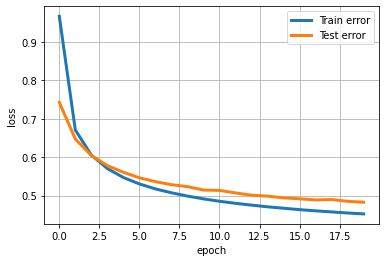

In [14]:
plt.plot(range(20),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(20),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

Evaluate on the entire dataset!

In [15]:
predicted_output = net(images)
print(torch.max(predicted_output, 1))
fit = Loss(predicted_output, labels)
print(labels)

torch.return_types.max(
values=tensor([ 6.2896,  2.9369,  8.8752,  7.8256,  6.6502,  6.1166, 10.2840,  4.4024,
         6.9430, 11.7230, 10.7692, 10.5526,  6.8271,  4.6317,  9.4169,  4.5867],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([3, 1, 7, 5, 8, 2, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0'))
tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0')


# Let's train the same network with momentum!

In [16]:
net = LinearReg().cuda()
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [17]:
train_loss_history = []
test_loss_history = []

for epoch in range(20):
  train_loss = 0.0
  test_loss = 0.0
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    predicted_output = net(images)
    fit = Loss(predicted_output,labels)
    fit.backward()
    optimizer.step()
    train_loss += fit.item()
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      predicted_output = net(images)
      fit = Loss(predicted_output,labels)
      test_loss += fit.item()
  train_loss = train_loss/len(trainDataLoader)
  test_loss = test_loss/len(testDataLoader)
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  print('Epoch %s, Train loss %s, Test loss %s'%(epoch, train_loss, test_loss))

Epoch 0, Train loss 0.6148353225386727, Test loss 0.5260410872614307
Epoch 1, Train loss 0.48182568427469175, Test loss 0.5285183208383573
Epoch 2, Train loss 0.4556893865341571, Test loss 0.4726920701136255
Epoch 3, Train loss 0.4433434591459821, Test loss 0.46397509962130506
Epoch 4, Train loss 0.43402539578073823, Test loss 0.4604047509325538
Epoch 5, Train loss 0.4258155945235732, Test loss 0.45819055720879015
Epoch 6, Train loss 0.4206020837621902, Test loss 0.46324583869071523
Epoch 7, Train loss 0.4181042107850758, Test loss 0.4489257181905637
Epoch 8, Train loss 0.41401359526269726, Test loss 0.4668219617217969
Epoch 9, Train loss 0.4120133772397092, Test loss 0.45846454267668874
Epoch 10, Train loss 0.40868419048183763, Test loss 0.4493254371889078
Epoch 11, Train loss 0.4067958887261368, Test loss 0.44262603456806987
Epoch 12, Train loss 0.4034050463645189, Test loss 0.44530604153302067
Epoch 13, Train loss 0.40164569376119924, Test loss 0.48582889424387815
Epoch 14, Train lo

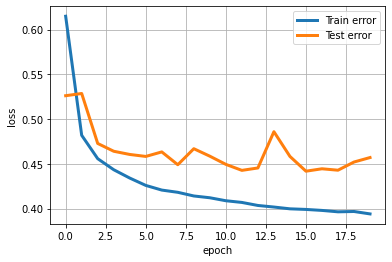

In [18]:
plt.plot(range(20),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(20),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()